In [2]:
import os, glob
import numpy as np
import pandas as pd
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
np.random.seed(42)

DATA_DIR = "data/multi_resolution"
SEQ_LEN = 64
FEATURE_COLS = ["open", "high", "low", "close", "r"]

# Binary labels 
# Bear* -> 0, Bull* -> 1
def pattern_to_binary(p):
    if isinstance(p, str):
        if p.startswith("Bear"):
            return 0
        if p.startswith("Bull"):
            return 1
    return None  

In [5]:
# Evaluation files
EVAL_FILES = [
    "1hour_sigma0.01.csv",
    "1minute_sigma0.005.csv",
    "1day_sigma0.02.csv"
]
EVAL_FILES = [os.path.join(DATA_DIR, f) for f in EVAL_FILES]

all_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.csv")))
train_files = [f for f in all_files if f not in EVAL_FILES]

print("Found files:", len(all_files))
print(*all_files[:20], sep="\n")
print("Train files:", len(train_files))
print("Eval files:", len(EVAL_FILES))
print("Overlap(train, eval) =", set(map(os.path.basename, train_files)).intersection(set(map(os.path.basename, EVAL_FILES))))

Found files: 17
data/multi_resolution\1day_sigma0.01.csv
data/multi_resolution\1day_sigma0.02.csv
data/multi_resolution\1day_sigma0.05.csv
data/multi_resolution\1day_sigma0.07.csv
data/multi_resolution\1day_sigma0.1.csv
data/multi_resolution\1hour_sigma0.005.csv
data/multi_resolution\1hour_sigma0.01.csv
data/multi_resolution\1hour_sigma0.02.csv
data/multi_resolution\1hour_sigma0.05.csv
data/multi_resolution\1minute_sigma0.001.csv
data/multi_resolution\1minute_sigma0.002.csv
data/multi_resolution\1minute_sigma0.005.csv
data/multi_resolution\1minute_sigma0.01.csv
data/multi_resolution\4hours_sigma0.005.csv
data/multi_resolution\4hours_sigma0.01.csv
data/multi_resolution\4hours_sigma0.02.csv
data/multi_resolution\4hours_sigma0.05.csv
Train files: 14
Eval files: 3
Overlap(train, eval) = set()


In [6]:
JUNK_COLS = {"Unnamed: 0", "Unnamed:0", "index", "level_0"}
REQUIRED_COLS = {"date", "open", "high", "low", "close", "r", "pattern"}

def load_and_clean_csv(path):
    cols = pd.read_csv(path, nrows=0).columns.tolist()
    cols = [c for c in cols if c not in JUNK_COLS]
    usecols = [c for c in cols if c in REQUIRED_COLS]

    df = pd.read_csv(path, usecols=usecols)
    df = df.drop(columns=[c for c in df.columns if c in JUNK_COLS], errors="ignore")

    missing = REQUIRED_COLS - set(df.columns)
    if missing:
        raise ValueError(f"{os.path.basename(path)} missing columns: {missing}")

    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df = df.dropna(subset=["date"]).sort_values("date")

    df["pattern"] = df["pattern"].fillna("no-pattern").astype(str)

    for c in FEATURE_COLS:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    df["r"] = df["r"].fillna(0.0)
    df = df.dropna(subset=["open", "high", "low", "close"])

    return df

In [7]:
# Convert dataframe to sequences
def df_to_sequences_binary(df):
    # drop no-pattern
    df = df[df["pattern"] != "no-pattern"].copy()
    if len(df) == 0:
        return None, None

    # keep only Bull & Bear
    df["bin"] = df["pattern"].apply(pattern_to_binary)
    df = df.dropna(subset=["bin"]).copy()
    df["bin"] = df["bin"].astype(int)
    if len(df) == 0:
        return None, None

    # group consecutive identical patterns (not bullish/bearish)
    df["group_id"] = (df["pattern"] != df["pattern"].shift(1)).cumsum()

    X_list, y_list = [], []

    for _, g in df.groupby("group_id"):
        y = int(g["bin"].iloc[0])
        feat = g[FEATURE_COLS].values.astype(np.float32)

        # pad/truncate to fixed length
        if len(feat) >= SEQ_LEN:
            seq = feat[-SEQ_LEN:]
        else:
            pad_len = SEQ_LEN - len(feat)
            pad = np.zeros((pad_len, feat.shape[1]), dtype=np.float32)
            seq = np.concatenate([pad, feat], axis=0)

        X_list.append(seq)
        y_list.append(y)

    if len(X_list) == 0:
        return None, None

    X = np.stack(X_list)              # (N, SEQ_LEN, F)
    y = np.array(y_list, dtype=int)   # (N,)
    return X, y

In [8]:
# Fit global scaler on train only (ignore padded zeros)
scaler = StandardScaler()

for path in train_files:
    df = load_and_clean_csv(path)
    X, y = df_to_sequences_binary(df)
    if X is None:
        continue

    Xp = X.reshape(-1, X.shape[-1])
    nonpad = ~(np.all(Xp == 0, axis=1))
    scaler.partial_fit(Xp[nonpad])

def scale_X(X):
    n, t, f = X.shape
    X2 = X.reshape(-1, f)
    X2 = scaler.transform(X2)
    return X2.reshape(n, t, f).astype(np.float32)

In [9]:
# Build datasets
def build_dataset_from_files(file_list):
    X_list, y_list = [], []
    for path in file_list:
        df = load_and_clean_csv(path)
        X, y = df_to_sequences_binary(df)
        if X is None:
            continue
        X = scale_X(X)
        X_list.append(X)
        y_list.append(y)

    if len(X_list) == 0:
        raise ValueError("No sequences found in the provided files.")

    X_all = np.concatenate(X_list, axis=0)
    y_all = np.concatenate(y_list, axis=0)
    return X_all, y_all

X_train_seq, y_train = build_dataset_from_files(train_files)
X_eval_seq,  y_eval  = build_dataset_from_files(EVAL_FILES)

print("Train seq shape:", X_train_seq.shape, y_train.shape)
print("Eval  seq shape:", X_eval_seq.shape,  y_eval.shape)
print("Train label counts:", Counter(y_train))
print("Eval label counts:", Counter(y_eval))

Train seq shape: (309035, 64, 5) (309035,)
Eval  seq shape: (38748, 64, 5) (38748,)
Train label counts: Counter({1: 155305, 0: 153730})
Eval label counts: Counter({0: 19415, 1: 19333})


In [10]:
# Flatten for SVM
Ntr, T, F = X_train_seq.shape
Nev = X_eval_seq.shape[0]

X_train_flat = X_train_seq.reshape(Ntr, T * F)
X_eval_flat  = X_eval_seq.reshape(Nev, T * F)

print("Train flat shape:", X_train_flat.shape)
print("Eval  flat shape:", X_eval_flat.shape)

Train flat shape: (309035, 320)
Eval  flat shape: (38748, 320)


In [11]:
# Train Linear SVM (binary)
svm = LinearSVC(
    C=1.0,
    class_weight="balanced",
    max_iter=30000,
    random_state=42
)
svm.fit(X_train_flat, y_train)

y_pred = svm.predict(X_eval_flat)

In [12]:
# Evaluation
target_names = ["Bearish", "Bullish"]
print("\nBinary classification report (SVM):")
print(classification_report(y_eval, y_pred, target_names=target_names, zero_division=0))

cm = confusion_matrix(y_eval, y_pred, labels=[0,1])


Binary classification report (SVM):
              precision    recall  f1-score   support

     Bearish       0.64      0.63      0.63     19415
     Bullish       0.63      0.65      0.64     19333

    accuracy                           0.64     38748
   macro avg       0.64      0.64      0.64     38748
weighted avg       0.64      0.64      0.64     38748



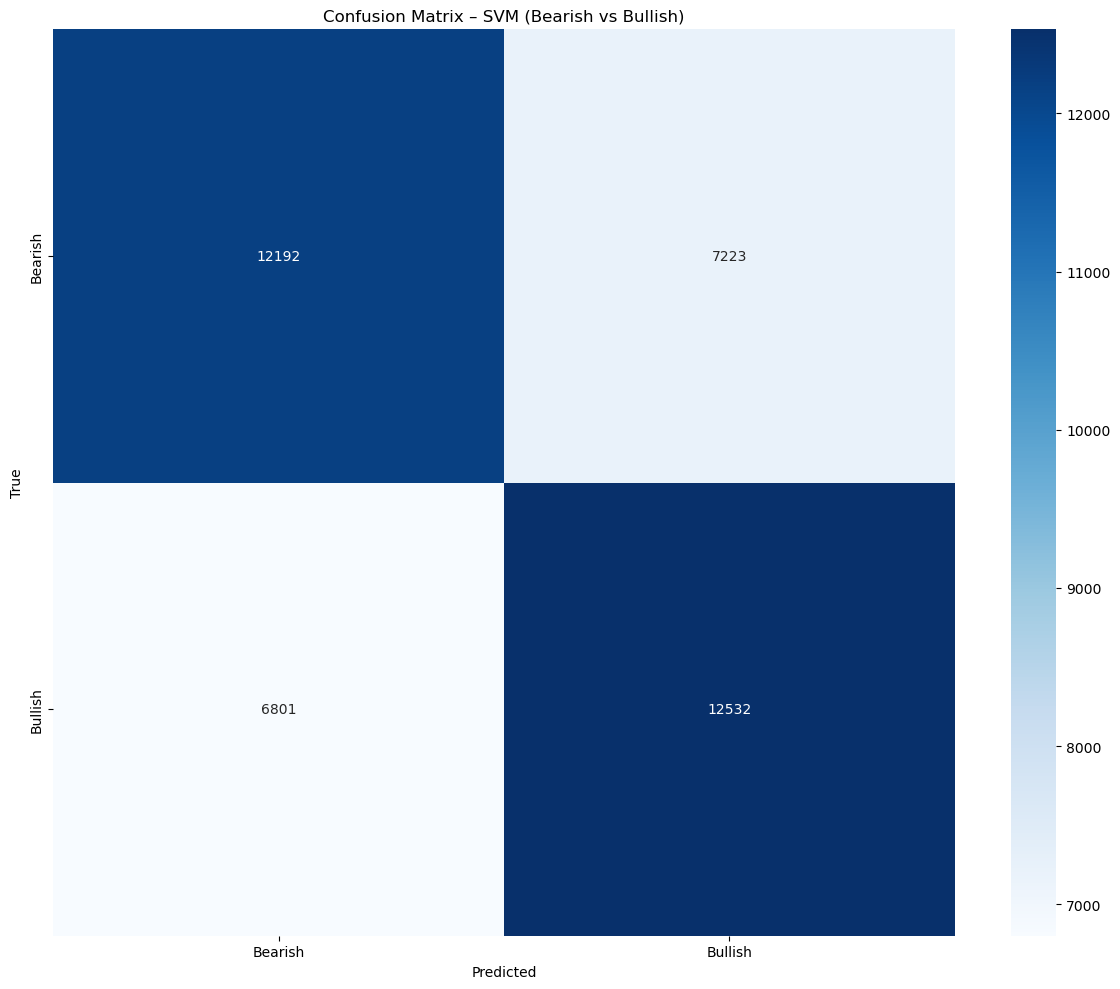

In [14]:
plt.figure(figsize=(12,10))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=target_names, yticklabels=target_names
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – SVM (Bearish vs Bullish)")
plt.tight_layout()
plt.show()